In [2]:
import os
import pandas as pd
import numpy as np
import json
import pickle
from collections import defaultdict
from pathlib import Path
from statistics import mean, stdev
from sklearn.metrics import ndcg_score, dcg_score
import matplotlib.pyplot as plt
import seaborn as sns

import torch

import os, sys
parentPath = os.path.abspath("..")
if parentPath not in sys.path:
    sys.path.insert(0, parentPath)
    
from src.data import load_source
from src.config import Config, get_option_fallback
from src.path import get_best_model_paths, get_exp_paths, get_report_path, load_json, load_rep_cfg, get_exp_names
from src.trainer import Trainer

In [3]:
# projectdir = Path('/code')
projectdir = Path('..')
assert projectdir.exists()

# Common Functions

In [3]:
def summarize_test_res(rep, folds=5):
    print(rep['config']['exp_name'], end=':\t')
    s = pd.Series([rep['best']['auc_epoch'][str(i)] for i in range(folds)])
    print(f'Best epoch at {s.mean():>6.1f}±{s.std():<5.1f}', end='\t')
    s = pd.Series([rep['best']['auc'][str(i)] for i in range(folds)])
    print(f'Valid AUC: {s.mean()*100:.4f}±{s.std()*100:.4f}', end='\t')
    s = pd.Series([rep['indicator']['test_auc'][str(i)][0] for i in range(folds)])
    print(f'Test AUC: {s.mean()*100:.4f}±{s.std()*100:.4f}', end='\t')
    s = rep['indicator']['RPsoft']['all']
    print(f'Good:Bad = {s["good"]}:{s["bad"]}', end='\t')
    s = rep['indicator']['test_auc']['all'][0]
    print(f'All Test AUC: {s*100:.4f}')

In [4]:
def show_valid_lc(name, idclist_dic, idc='eval_auc'):
    min_len = min([len(_x) for _x in idclist_dic['epoch'].values()])
    x = idclist_dic['epoch']['0'][:min_len] * (len(idclist_dic['epoch']) -1)  # exclude 'all'
    y = []
    for _y in idclist_dic[idc].values():
        y += _y[:min_len]
    sns.lineplot(x=x, y=y, label=name)
    plt.title(idc)

In [5]:
def summarize_results(config_name, folds=5):
    report_paths = [get_report_path(projectdir, config_name, e) for e in get_exp_names(projectdir, config_name)]
    reports = [load_json(r) for r in report_paths]
    df = pd.DataFrame(columns=['dataset', 'model', 'auc', 'auc_std', 'r1_good', 'r1_goodbad', 'r2', 'r2_std'])
    for r in reports:
        row = {
            'dataset':   r['config']['config_name'],
            'model':     r['config']['exp_name'],
            'auc':       mean([r['indicator']['test_auc'][str(i)][0] for i in range(folds)]),
            'auc_std':   stdev([r['indicator']['test_auc'][str(i)][0] for i in range(folds)]) if folds > 1 else np.nan,
            'r1_good':       r['indicator']['RPsoft']['all']['good'],
            'r1_goodbad':       r['indicator']['RPsoft']['all']['good'] + r['indicator']['RPsoft']['all']['bad'],
            'r2':      mean(r['indicator']['RPhard']['all']),
            'r2_std': stdev(r['indicator']['RPhard']['all'])
        }
        df = df.append(row, ignore_index=True)
    return df
        

# Summary

## AUC table

In [6]:
summarize_results('20_0310_edm2020_assist09')

,dataset,model,auc,auc_std,r1_good,r1_goodbad,r2,r2_std
0,20_0310_edm2020_assist09,pre_dummy_epoch_size150.auto,0.805398,0.000801,106,110,0.897429,0.112539
1,20_0310_edm2020_assist09,pre_dummy_epoch_size10.auto,0.802763,0.001107,105,110,0.916217,0.103119
2,20_0310_edm2020_assist09,pre_dummy_epoch_size0.auto,0.802399,0.002135,91,110,0.885842,0.121002


In [7]:
summarize_results('20_0310_edm2020_assist15')

,dataset,model,auc,auc_std,r1_good,r1_goodbad,r2,r2_std
0,20_0310_edm2020_assist15,pre_dummy_epoch_size150.auto,0.705414,0.001263,95,100,0.927833,0.092699
1,20_0310_edm2020_assist15,pre_dummy_epoch_size10.auto,0.703355,0.000890,99,100,0.921136,0.096746
2,20_0310_edm2020_assist15,pre_dummy_epoch_size0.auto,0.703117,0.001366,99,100,0.924388,0.091456


In [8]:
summarize_results('20_0310_edm2020_synthetic', folds=1)

,dataset,model,auc,auc_std,r1_good,r1_goodbad,r2,r2_std
0,20_0310_edm2020_synthetic,pre_dummy_epoch_size150.auto,0.773313,NaN,46,50,0.890824,0.113911
1,20_0310_edm2020_synthetic,pre_dummy_epoch_size10.auto,0.776778,NaN,44,50,0.894807,0.115647
2,20_0310_edm2020_synthetic,pre_dummy_epoch_size0.auto,0.777116,NaN,26,50,0.792350,0.130606


In [9]:
summarize_results('20_0310_edm2020_statics')

,dataset,model,auc,auc_std,r1_good,r1_goodbad,r2,r2_std
0,20_0310_edm2020_statics,pre_dummy_epoch_size150.auto,0.792491,0.000426,716,1223,0.809500,0.158295
1,20_0310_edm2020_statics,pre_dummy_epoch_size10.auto,0.794149,0.003777,934,1223,0.885513,0.126757
2,20_0310_edm2020_statics,pre_dummy_epoch_size0.auto,0.787167,0.000661,639,1223,0.778891,0.149663


In [10]:
print(summarize_results('20_0310_edm2020_assist09').to_latex())
print(summarize_results('20_0310_edm2020_assist15').to_latex())
print(summarize_results('20_0310_edm2020_synthetic', folds=1).to_latex())
print(summarize_results('20_0310_edm2020_statics').to_latex())

\begin{tabular}{lllrrllrr}
\toprule
{} &                   dataset &                         model &       auc &   auc\_std & r1\_good & r1\_goodbad &        r2 &    r2\_std \\
\midrule
0 &  20\_0310\_edm2020\_assist09 &  pre\_dummy\_epoch\_size150.auto &  0.805398 &  0.000801 &     106 &        110 &  0.897429 &  0.112539 \\
1 &  20\_0310\_edm2020\_assist09 &   pre\_dummy\_epoch\_size10.auto &  0.802763 &  0.001107 &     105 &        110 &  0.916217 &  0.103119 \\
2 &  20\_0310\_edm2020\_assist09 &    pre\_dummy\_epoch\_size0.auto &  0.802399 &  0.002135 &      91 &        110 &  0.885842 &  0.121002 \\
\bottomrule
\end{tabular}

\begin{tabular}{lllrrllrr}
\toprule
{} &                   dataset &                         model &       auc &   auc\_std & r1\_good & r1\_goodbad &        r2 &    r2\_std \\
\midrule
0 &  20\_0310\_edm2020\_assist15 &  pre\_dummy\_epoch\_size150.auto &  0.705414 &  0.001263 &      95 &        100 &  0.927833 &  0.092699 \\
1 &  20\_0310\_edm2020\_assist15 

## NDCG distplot

In [66]:
def ndcg_distplot(config_name, ax, idx, label_names, bins=20):
    report_paths = [get_report_path(projectdir, config_name, e) for e in get_exp_names(projectdir, config_name)]
    reports = [load_json(r) for r in report_paths]
    for rep in reports:
        if rep['config']['pre_dummy_epoch_size'] not in {0, 10}:
            continue
        r = rep['indicator']['RPhard']['all']
        name = rep['config']['exp_name']
        sns.distplot(r, ax=ax,bins=bins, label=label_names[name], kde_kws={'clip': (0.0, 1.0)})
    ax.set_xlabel('NDCG score')
    if idx == 0:
        ax.set_ylabel('frequency')
    if idx == 3:
        ax.legend()
    ax.set_title(label_names[config_name])
    ax.set_xlim([0.59, 1.01])
    ax.title.set_fontsize(18)
    ax.xaxis.label.set_fontsize(14)
    ax.yaxis.label.set_fontsize(14)

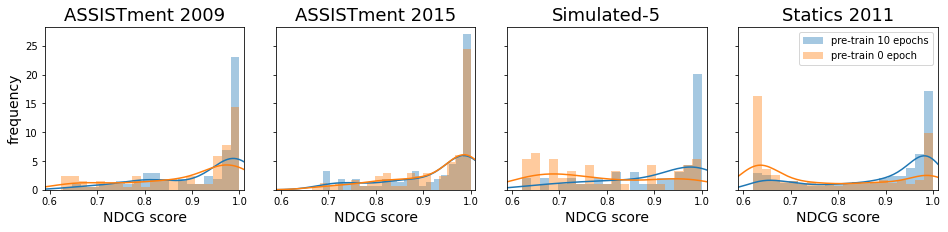

In [95]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(4*4,3))
# plt.subplots_adjust(hspace=0.3)
fig.subplots_adjust(hspace=.1, wspace=.16)
label_names = {
    '20_0310_edm2020_assist09' : 'ASSISTment 2009',
    '20_0310_edm2020_assist15' : 'ASSISTment 2015',
    '20_0310_edm2020_synthetic': 'Simulated-5',
    '20_0310_edm2020_statics'  : 'Statics 2011',
    'pre_dummy_epoch_size10.auto': 'pre-train 10 epochs',
    'pre_dummy_epoch_size0.auto': 'pre-train 0 epoch',
}
ndcg_distplot('20_0310_edm2020_assist09' , ax=axs[0], idx=0, label_names=label_names)
ndcg_distplot('20_0310_edm2020_assist15' , ax=axs[1], idx=1, label_names=label_names)
ndcg_distplot('20_0310_edm2020_synthetic', ax=axs[2], idx=2, label_names=label_names)
ndcg_distplot('20_0310_edm2020_statics'  , ax=axs[3], idx=3, label_names=label_names)

## Learning curve

In [91]:
def lc_plot(config_name, ax, idx, label_names):
    report_paths = [get_report_path(projectdir, config_name, e) for e in get_exp_names(projectdir, config_name)]
    reports = [load_json(r) for r in report_paths]
    for r in reports:
        if r['config']['pre_dummy_epoch_size'] not in {0, 10}:
            continue
        idclist_dic = r['indicator']
        idc = 'eval_auc'
        min_len = min([len(_x) for _x in idclist_dic['epoch'].values()])
        x = idclist_dic['epoch']['0'][:min_len] * (len(idclist_dic['epoch']) -1)  # exclude 'all'
        y = []
        for _y in idclist_dic[idc].values():
            y += _y[:min_len]
        sns.lineplot(x=x, y=y, ax=ax, label=label_names[r['config']['exp_name']], ci='sd')
    ax.set_xlabel('epoch')
    if idx == 0:
        ax.set_ylabel('AUC')
    if idx == 3:
        ax.legend()
    else:
        ax.get_legend().remove()
    ax.set_title(label_names[config_name])
    ax.title.set_fontsize(18)
    ax.xaxis.label.set_fontsize(14)
    ax.yaxis.label.set_fontsize(14)

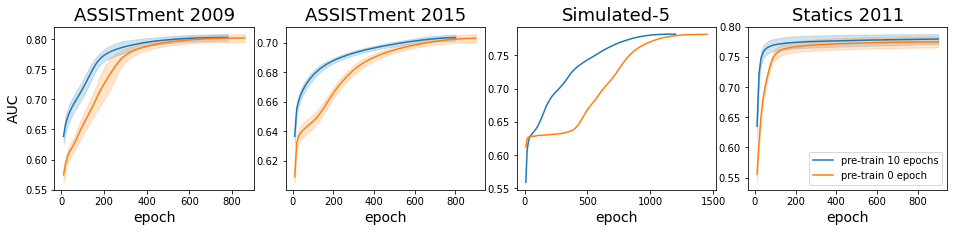

In [92]:
fig, axs = plt.subplots(1, 4, sharey=False, figsize=(4*4,3))
# plt.subplots_adjust(hspace=0.3)
fig.subplots_adjust(hspace=.1, wspace=.16)
label_names = {
    '20_0310_edm2020_assist09' : 'ASSISTment 2009',
    '20_0310_edm2020_assist15' : 'ASSISTment 2015',
    '20_0310_edm2020_synthetic': 'Simulated-5',
    '20_0310_edm2020_statics'  : 'Statics 2011',
    'pre_dummy_epoch_size10.auto': 'pre-train 10 epochs',
    'pre_dummy_epoch_size0.auto': 'pre-train 0 epoch',
}
lc_plot('20_0310_edm2020_assist09' , ax=axs[0], idx=0, label_names=label_names)
lc_plot('20_0310_edm2020_assist15' , ax=axs[1], idx=1, label_names=label_names)
lc_plot('20_0310_edm2020_synthetic', ax=axs[2], idx=2, label_names=label_names)
lc_plot('20_0310_edm2020_statics'  , ax=axs[3], idx=3, label_names=label_names)
plt.show()

# `20_0310_edm2020_assist09`

## Simulated curve

In [ ]:
config_name = '20_0310_edm2020_assist09'
report_list = []
for r in sorted([load_json(get_report_path(projectdir, e)) for e in get_exp_paths(projectdir, config_name)], key=lambda x: x['config']['pre_dummy_epoch_size']):
    if r['config']['pre_dummy_epoch_size'] not in {0, 10}:
        continue
    r['config']['exp_name'] = f"DKT pre {r['config']['pre_dummy_epoch_size']}"
    report_list.append(r)

[r['config']['exp_name'] for r in report_list]

In [ ]:
def get_simu_res(report_dic):
    return report_dic['indicator']['simu_pred']['all']

simures_list = []
for r in report_list:
    simu_res = get_simu_res(r)
    simures_list.append(simu_res)
    
base_idx = 0
base_res = {k:v for k, v in sorted(simures_list[base_idx].items(), key=lambda it: it[1][1][-1] - it[1][1][0])}
descres_list = []
for i, simu_res in enumerate(simures_list):
    if i == base_idx:
        continue
    desc_res = {k:simu_res[k] for k in base_res.keys()}
    descres_list.append(desc_res)

In [ ]:
n_skills = report_list[base_idx]['config']['n_skills']
h, w = (n_skills+7)//8, 8
figscale = 2.5
hspace = 0.35
fig, axs = plt.subplots(h, w, figsize=(w*figscale, h*figscale))
plt.subplots_adjust(hspace=hspace)
for i, (v, (xidx, sanity)) in enumerate(list(base_res.items())[:h*w]):
    ax = axs[i//(w), i%(w)]
    ax.set_ylim([0, 1])
    ax.set_title('KC{}'.format(v))
    sns.lineplot(xidx, sanity, ax=ax, label='base', palette="ch:2.5,.25")
    for i, desc_res in enumerate(descres_list):
        sns.lineplot(xidx, desc_res[v][1], ax=ax, label=str(i+1), palette="ch:2.5,.25")
    ax.get_legend().remove()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.show()

## Single ones

In [ ]:
def plot_single(kc):
    x, y = base_res[str(kc)]
    sns.lineplot(x=x, y=y)
plot_single(78)

In [ ]:
f, axs = plt.subplots(1, 3, sharey=True, figsize=(12,3))
f.tight_layout()
for i, (kc, ax) in enumerate(zip([30, 83, 98], axs)):
    ax.set_ylim([0, 1])
    x, y = base_res[str(kc)]
    sns.lineplot(x=x, y=y, ax=ax)
    ax.set_title(f'KC{kc}')
    ax.set_ylabel('predicted accuracy')
    ax.set_xlabel('$k$\n({})'.format(['a','b','c'][i]))
plt.show()

## NDCG

In [ ]:
for rep in report_list:
    r = rep['indicator']['RPhard']['all']
    name = rep['config']['exp_name']
    sns.distplot(r, bins=10, label=name, kde_kws={'clip': (0.0, 1.0)})
    print(f'{name:<20s}\t{mean(r):.4f}±{stdev(r):.4f}')
plt.legend()
plt.show()

In [ ]:
for rep in report_list:
    r = rep['indicator']['RPsoft']['all']
    name = rep['config']['exp_name']
    print(f'{name:<20s}\tGood:Bad = {r["good"]}:{r["bad"]}')

## Learning curve

In [ ]:
for r in report_list:
    show_valid_lc(r['config']['exp_name'], r['indicator'])
plt.show()

In [ ]:
for r in report_list:
    show_valid_lc(r['config']['exp_name'], r['indicator'], idc='eval_loss')
plt.show()

## Test AUC

In [ ]:
for r in report_list:
    summarize_test_res(r)

# `Debug`

## Simulated curve

In [ ]:
def get_simu_res(report_dic):
    return report_dic['indicator']['simu_pred']['all']

simures_list = []
for r in report_list:
    simu_res = get_simu_res(r)
    simures_list.append(simu_res)
    
base_idx = 0
base_res = {k:v for k, v in sorted(simures_list[base_idx].items(), key=lambda it: it[1][1][-1] - it[1][1][0])}
descres_list = []
for i, simu_res in enumerate(simures_list):
    if i == base_idx:
        continue
    desc_res = {k:simu_res[k] for k in base_res.keys()}
    descres_list.append(desc_res)

## NDCG

In [ ]:
for rep in report_list:
    r = rep['indicator']['RPsoft']['all']
    name = rep['config']['exp_name']
    print(f'{name:<20s}\tGood:Bad = {r["good"]}:{r["bad"]}')

In [ ]:
for r in report_list:
    show_valid_lc(r['config']['exp_name'], r['indicator'])
plt.show()

## Test AUC

## Simulated curve

In [ ]:
def get_simu_res(report_dic):
    return report_dic['indicator']['simu_pred']['all']


simures_list = []
for r in report_list:
    simu_res = get_simu_res(r)
    simures_list.append(simu_res)
    

base_idx = 1
base_res = {k:v for k, v in sorted(simures_list[base_idx].items(), key=lambda it: it[1][1][-1] - it[1][1][0])}
descres_list = []
for i, simu_res in enumerate(simures_list):
    if i == base_idx:
        continue
    desc_res = {k:simu_res[k] for k in base_res.keys()}
    descres_list.append(desc_res)

## NDCG

In [ ]:
for rep in report_list:
    r = rep['indicator']['RPsoft']['all']
    name = rep['config']['exp_name']
    print(f'{name:<20s}\tGood:Bad = {r["good"]}:{r["bad"]}')

## Learning curve

In [ ]:
for r in report_list:
    show_valid_lc(r['config']['exp_name'], r['indicator'])
plt.show()

## Test AUC

In [ ]:
def summarize_test_res(rep):
    print(rep['config']['exp_name'], end=':\t')
    s = pd.Series([rep['best']['auc_epoch'][str(i)] for i in range(5)])
    print(f'Best epoch at {s.mean():>6.1f}±{s.std():<5.1f}', end='\t')
    s = pd.Series([rep['best']['auc'][str(i)] for i in range(5)])
    print(f'Valid AUC: {s.mean()*100:.4f}±{s.std()*100:.4f}', end='\t')
    s = rep['indicator']['test_auc']['all'][0]
    print(f'Test AUC: {s*100:.4f}')

In [ ]:
for r in report_list:
    summarize_test_res(r)

# `20_0310_edm2020_synthetic`

## Simulated curve

In [ ]:
config_name = '20_0310_edm2020_synthetic'
report_list = []
for r in sorted([load_json(get_report_path(projectdir, e)) for e in get_exp_paths(projectdir, config_name)], key=lambda x: x['config']['pre_dummy_epoch_size']):
    report_list.append(r)

[r['config']['exp_name'] for r in report_list]

In [ ]:
def get_simu_res(report_dic):
    return report_dic['indicator']['simu_pred']['all']

simures_list = []
for r in report_list:
    simu_res = get_simu_res(r)
    simures_list.append(simu_res)
    
base_idx = 0
base_res = {k:v for k, v in sorted(simures_list[base_idx].items(), key=lambda it: it[1][1][-1] - it[1][1][0])}
descres_list = []
for i, simu_res in enumerate(simures_list):
    if i == base_idx:
        continue
    desc_res = {k:simu_res[k] for k in base_res.keys()}
    descres_list.append(desc_res)

In [ ]:
n_skills = report_list[base_idx]['config']['n_skills']
h, w = (n_skills+7)//8, 8
figscale = 2.5
hspace = 0.35
fig, axs = plt.subplots(h, w, figsize=(w*figscale, h*figscale))
plt.subplots_adjust(hspace=hspace)
for i, (v, (xidx, sanity)) in enumerate(list(base_res.items())[:h*w]):
    ax = axs[i//(w), i%(w)]
    ax.set_ylim([0, 1])
    ax.set_title('KC{} s{}0'.format(v, '>' if sanity[-1]>sanity[0] else '<'))
    sns.lineplot(xidx, sanity, ax=ax, label='base', palette="ch:2.5,.25")
    for i, desc_res in enumerate(descres_list):
        sns.lineplot(xidx, desc_res[v][1], ax=ax, label=str(i+1), palette="ch:2.5,.25")
    ax.get_legend().remove()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.show()

## NDCG

In [ ]:
for rep in report_list:
    r = rep['indicator']['RPhard']['all']
    name = rep['config']['exp_name']
    sns.distplot(r, bins=10, label=name, kde_kws={'clip': (0.0, 1.0)})
    print(f'{name:<20s}\t{mean(r):.4f}±{stdev(r):.4f}')
plt.legend()
plt.show()

In [ ]:
for rep in report_list:
    r = rep['indicator']['RPsoft']['all']
    name = rep['config']['exp_name']
    print(f'{name:<20s}\tGood:Bad = {r["good"]}:{r["bad"]}')

## Learning curve

In [ ]:
for r in report_list:
    show_valid_lc(r['config']['exp_name'], r['indicator'])
plt.show()

In [ ]:
for r in report_list:
    show_valid_lc(r['config']['exp_name'], r['indicator'])
plt.show()

## Test AUC

In [ ]:
for r in report_list:
    show_valid_lc(r['config']['exp_name'], r['indicator'], idc='eval_loss')
    summarize_test_res(r, folds=1)
plt.show()

## Test AUC

In [ ]:
for r in report_list:
    show_valid_lc(r['config']['exp_name'], r['indicator'])
plt.show()

## Learning curve

In [ ]:
for rep in report_list:
    r = rep['indicator']['RPsoft']['all']
    name = rep['config']['exp_name']
    print(f'{name:<20s}\tGood:Bad = {r["good"]}:{r["bad"]}')

# `20_0310_edm2020_assist15`

## Simulated curve

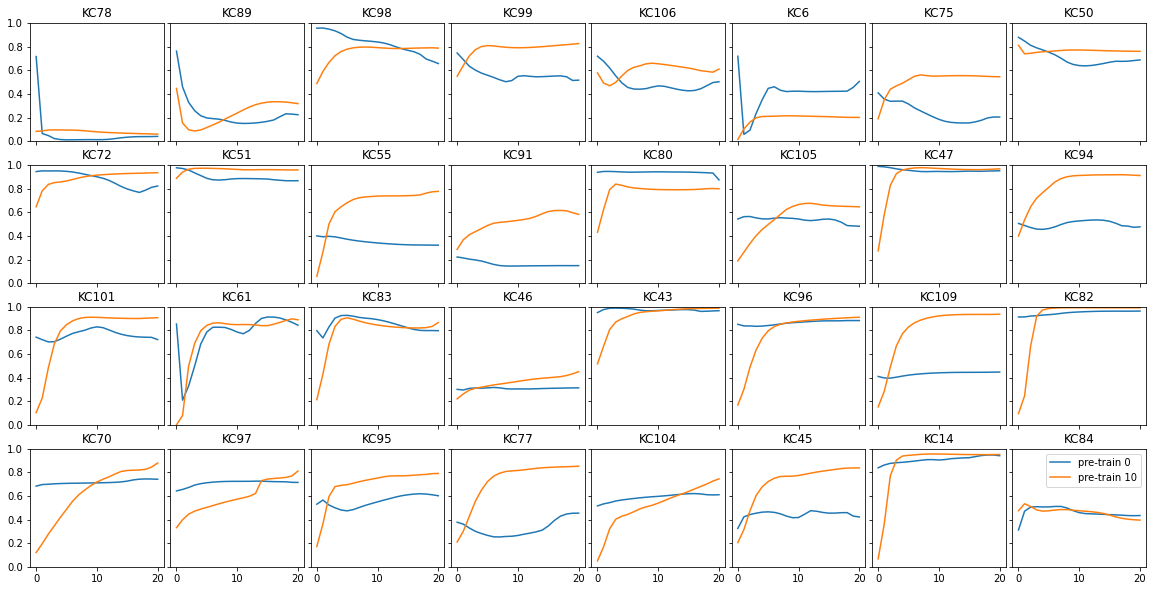

In [26]:
# config_name = '20_0310_edm2020_assist15'
config_name = '20_0310_edm2020_assist09'

report_paths = [get_report_path(projectdir, config_name, e) for e in get_exp_names(projectdir, config_name)]
reports = [load_json(r) for r in report_paths]
    

# print([r['config']['exp_name'] for r in reports])
# =>['pre_dummy_epoch_size150.auto', 'pre_dummy_epoch_size10.auto', 'pre_dummy_epoch_size0.auto']

def get_simu_res(report_dic):
    return report_dic['indicator']['simu_pred']['all']

simures_list = []
for r in reports:
    if r['config']['pre_dummy_epoch_size'] not in {0, 10}:
        continue
    simu_res = get_simu_res(r)
    simures_list.append(simu_res)
    
base_idx = 1
base_res = {k:v for k, v in sorted(simures_list[base_idx].items(), key=lambda it: it[1][1][-1] - it[1][1][0])}
descres_list = []
for i, simu_res in enumerate(simures_list):
    if i == base_idx:
        continue
    desc_res = {k:simu_res[k] for k in base_res.keys()}
    descres_list.append(desc_res)

n_skills = reports[base_idx]['config']['n_skills']
# h, w = (n_skills+7)//8, 8
h, w = 4, 8
figscale = 2.5
hspace = 0.35
fig, axs = plt.subplots(h, w, sharex=True, sharey=True, figsize=(w*figscale, h*figscale))
plt.subplots_adjust(hspace=0.20, wspace=0.05)
for i, (v, (xidx, sanity)) in enumerate(list(base_res.items())[:h*w]):
    ax = axs[i//(w), i%(w)]
    ax.set_ylim([0, 1])
    ax.set_title(f'KC{v}')
    sns.lineplot(xidx, sanity, ax=ax, label='pre-train 0', palette="ch:2.5,.25")
    for j, desc_res in enumerate(descres_list):
        sns.lineplot(xidx, desc_res[v][1], ax=ax, label=f'pre-train {[10,150][j]}', palette="ch:2.5,.25")
    if i < 31:
        ax.get_legend().remove()
    else:
        ax.legend()
        break
# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center')
plt.show()

## NDCG

In [ ]:
for rep in report_list:
    r = rep['indicator']['RPhard']['all']
    name = rep['config']['exp_name']
    sns.distplot(r, bins=20, label=name, kde_kws={'clip': (0.0, 1.0)})
    print(f'{name:<20s}\t{mean(r):.4f}±{stdev(r):.4f}')
plt.legend()
plt.show()

## Learning curve AUC

In [ ]:
for r in report_list:
    show_valid_lc(r['config']['exp_name'], r['indicator'])
    summarize_test_res(r)
plt.show()

In [ ]:
for r in report_list:
    show_valid_lc(r['config']['exp_name'], r['indicator'], idc='eval_loss')
plt.show()